In [1]:
# Common useful packages
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
import importlib
import numpy as np
import copy
import spectral
import pickle
import os

# local imports
#import hyperspectral_gta_data as hsi_data
from hsiViewer import hsi_viewer_layers as hvl
from hsiViewer import hsi_viewer_ROI as hvr
from hsiViewer import hsi_viewer as hsv
import microscene_functions as msf

# set the directory where data will be downloaded and accessed
# (This directory will be saved in a config file and used each time you use hyperspectral_gta_data, 
# so you don't need to run the 'set_data_dir' function every time you use hyperspectral_gta_data.)
#hsi_data.set_data_dir('C:/spectral_data')

# Part 1: Open the image and load the data as a numpy array.

## NOTE: This assumes that you have the filename for the hyperspectral image along with the ROI .pkl file.

In [23]:
# filename for the image
fname = 'C:/spectral_data/spectral_images/Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref'
fname_hdr = 'C:/spectral_data/spectral_images/Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref.hdr'
# ROI file fname
fname_roi = 'C:\\spectral_data\\spectral_images\\UPWINS Baccharis Halimifolia.pkl'

In [2]:
# filename for the image
fname = 'data/4-10-2025/100124_HarrisMicro_20250410_2015_06_04_17_52_31/raw_0_ref'
fname_hdr = 'data/4-10-2025/100124_HarrisMicro_20250410_2015_06_04_17_52_31/raw_0_ref.hdr'
# ROI file fname
fname_roi = 'data/pkl/ROIs_4-10_Chas_lat.pkl'

In [3]:
# Open the image and read into an array
im = spectral.envi.open(fname_hdr, fname)
wl = np.asarray(im.bands.centers)
# Load the image into memory
im.Arr = im.load()
print(f'Shape of Im.Arr = {im.Arr.shape}')
im.List = np.reshape(im.Arr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of im.List = {im.List.shape}')
dataList = im.List[np.sum(im.List, axis=1)>0, :]
print(f'Shape of dataList = {dataList.shape}')
nr = im.nrows
nc = im.ncols
nb = im.nbands

Shape of Im.Arr = (2999, 398, 272)
Shape of im.List = (1193602, 272)
Shape of dataList = (1193598, 272)


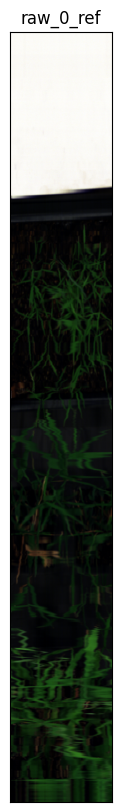

In [4]:
# Plot an RGB image of the hyperspectral image
# make the RGB image from the hyperspectral image (select RGB bands and applying stretch)
RGB_image = msf.make_rgb(im.Arr, wl, stretch = [2,98])
# Plot the image
plt.figure(figsize=(10,10))
plt.imshow(RGB_image)
plt.xticks([])
plt.yticks([])
plt.title(os.path.basename(fname));

# Part 2: Initial Evaluation of ROIs

In [5]:
# Unpickling the dictionary
with open(fname_roi, 'rb') as f:
    roiData = pickle.load(f)

In [6]:
df = roiData.df # a DataFrame holding all the data for the ROIs
roi_names = roiData.names # the names of the ROIs
roi_colors = roiData.colors # a Python dictionary of colors, where colors[class_name] will provide the color for class class_name
roi_masks = roiData.masks # a Python dictionary of location masks, where colors[class_name] will provide the numpy array for the mask
nClasses = len(roi_names)

# Notes:
#   Each mask is an array of bollean values of the same dimensions as the image, 
#   and True represents a pixel in the ROI while False represents not in the ROI.

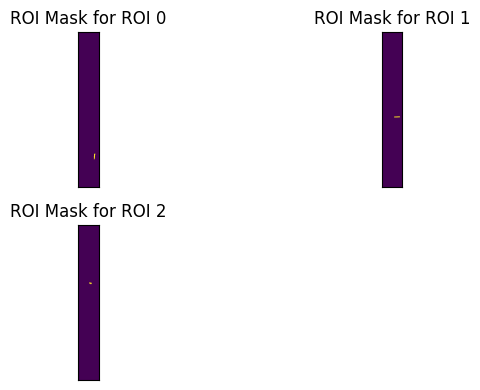

In [7]:
# determine how many rows of images (assuming each row has 2 masks)
nRowsPlots = int(np.ceil(nClasses/2)) # (change size of figure as needed)
plt.figure(figsize=(8, nRowsPlots*2))
for i in range(nClasses):
    name = roi_names[i]
    # create the subplot
    plt.subplot(nRowsPlots, 2, i+1)    
    plt.imshow(roi_masks[name])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'ROI Mask for {name}');
    plt.tight_layout()

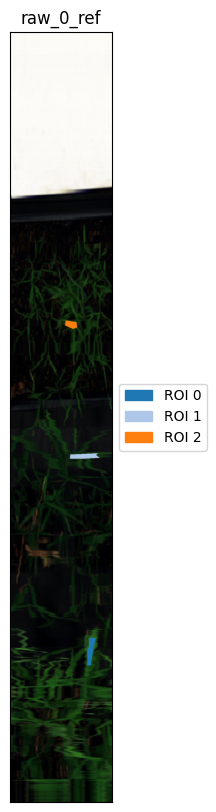

In [8]:
# Examine the locations
# create an RGB image
RGB_image_with_ROIs = msf.make_rgb(im.Arr, wl, stretch = [2,98])
# Add the ROI locations
for name in roi_names:
    # get the color for this ROI, converted from hex to (r,g,b)
    color = colors.to_rgb(roi_colors[name])
    mask = roi_masks[name]
    # set the pixel values for this ROI to (0,0,0)
    for i in range(3):
        RGB_image_with_ROIs[:,:,i] = RGB_image_with_ROIs[:,:,i]*(mask==False)
    # set the pixel values for this ROI to the color for this ROI
    for i in range(3):
        RGB_image_with_ROIs[:,:,i] = RGB_image_with_ROIs[:,:,i] + mask*color[i]

# Plot the image
plt.figure(figsize=(10,10))
plt.imshow(RGB_image_with_ROIs)
plt.xticks([])
plt.yticks([])
plt.title(os.path.basename(fname));
# Create legend patches: each patch is a colored box with the ROI name.
legend_patches = [mpatches.Patch(color=roi_colors[name], label=name) for name in roi_names]
# Add the legend to the right of the image
plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5))


In [9]:
# Examine the dataframe
df

,Name,Color,Pixel_x,Pixel_y,399.606453,401.827297,404.04814,406.268984,408.489827,410.710671,...,981.467464,983.688307,985.909151,988.129994,990.350838,992.571681,994.792525,997.013368,999.234212,1001.455055
0,Soli_sem,#fa3232,1549,429,0.012250,-0.050967,0.108857,0.097727,0.109796,-0.008968,...,0.299516,0.272623,0.291172,0.284914,0.299789,0.288951,0.295179,0.312537,0.298670,0.361600
1,Soli_sem,#fa3232,1550,429,0.146707,0.098894,0.100213,0.067216,0.043556,0.034982,...,0.287091,0.249073,0.286776,0.310389,0.316420,0.293885,0.266430,0.309812,0.309860,0.320634
2,Soli_sem,#fa3232,1551,429,-0.021364,0.080161,0.013774,0.006192,0.070052,-0.008968,...,0.295375,0.296172,0.275787,0.282598,0.311668,0.301286,0.289952,0.290736,0.284682,0.308930
3,Soli_sem,#fa3232,1552,429,-0.077388,0.061429,0.022418,0.105355,0.036932,-0.015246,...,0.266382,0.315440,0.269194,0.273334,0.285533,0.328424,0.300407,0.263485,0.290277,0.297225
4,Soli_sem,#fa3232,1553,429,0.023454,0.052062,0.048350,0.120611,0.076676,0.053817,...,0.297445,0.304735,0.271392,0.282598,0.302165,0.279082,0.282112,0.296187,0.301467,0.311856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5180,Background,#ff7f0e,1248,221,0.230646,0.030596,0.224498,0.110013,0.129915,0.036573,...,0.078743,0.071068,0.090011,0.073166,0.079679,0.073124,0.095641,0.059199,0.085684,0.080499
5181,Background,#ff7f0e,1249,221,0.142253,0.082183,0.153440,0.070750,0.105829,0.081094,...,0.084417,0.082800,0.083802,0.064811,0.088490,0.070774,0.057329,0.069195,0.067376,0.066890
5182,Background,#ff7f0e,1250,221,0.283682,0.099379,0.203181,0.083838,0.123894,0.097790,...,0.093874,0.086711,0.085871,0.064811,0.044438,0.035529,0.081274,0.081690,0.059530,0.045116
5183,Background,#ff7f0e,1251,221,0.106896,0.056389,0.110805,0.129645,0.087765,0.069964,...,0.071177,0.084756,0.090011,0.083611,0.059856,0.061375,0.071696,0.066696,0.075222,0.077777


In [10]:
spectra = df.to_numpy()[:,4:] # an array that holds all the spectra (each row is a spectrum)
spectra = spectra.astype(np.float32)
spectra_names = df['Name'].to_numpy()

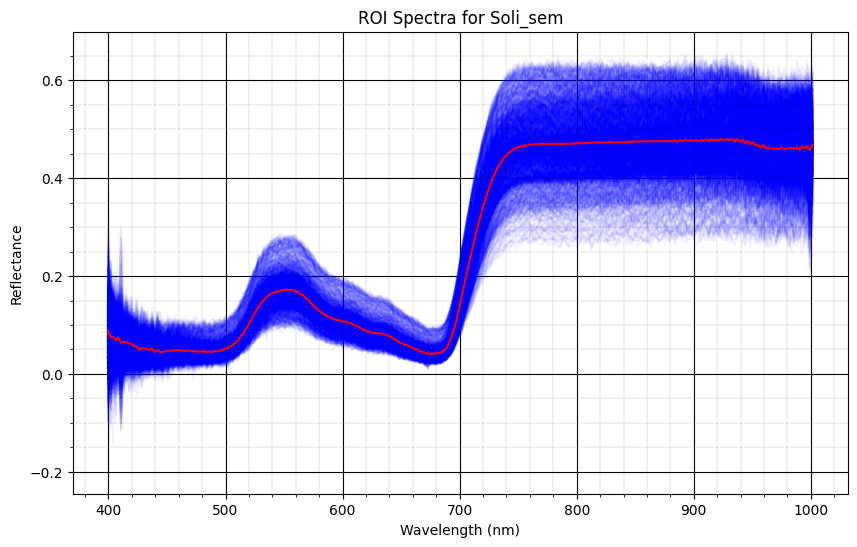

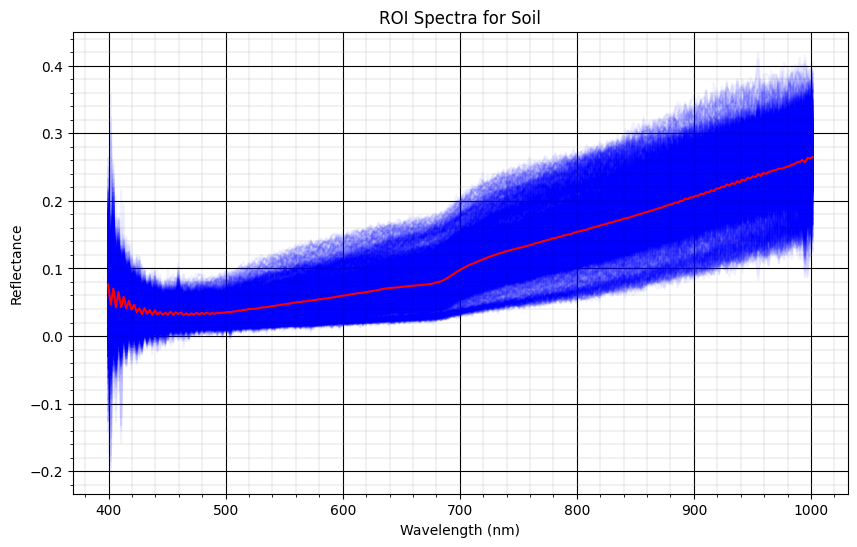

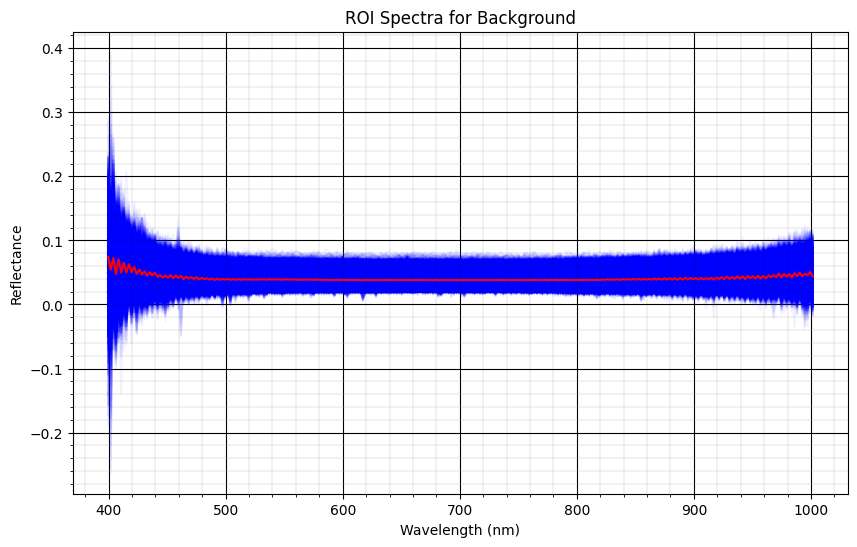

In [11]:
# plot the mean (red) and all individual spectra (blue) of each class
# we save the mean for each class for use later
means = {}
for name in roi_names:
    class_spectra = spectra[spectra_names==name,:]
    class_nSpec = class_spectra.shape[0]
    plt.figure(figsize=(10,6)) 
    for i in range(class_nSpec):
        plt.plot(wl,class_spectra[i,:].flatten(), color='b', alpha=0.05)
    means[name] = np.mean(class_spectra, axis=0)
    plt.plot(wl, means[name], color='r')
    plt.minorticks_on()
    plt.grid(True, which='major', c='k')
    plt.grid(True, which='minor', linewidth=0.25)
    plt.title(f'ROI Spectra for {name}')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.grid(True)

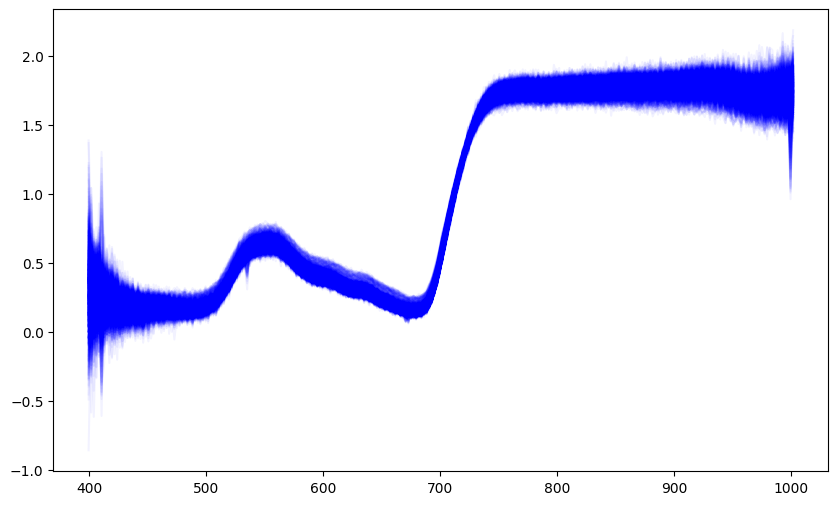

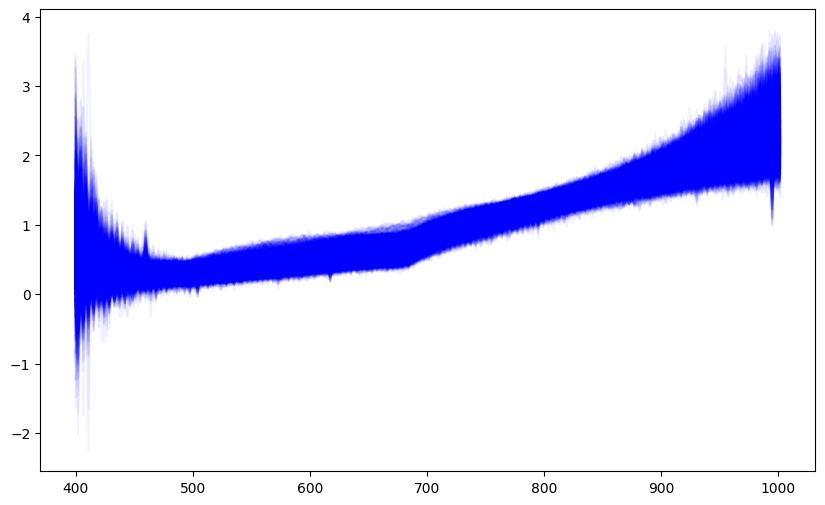

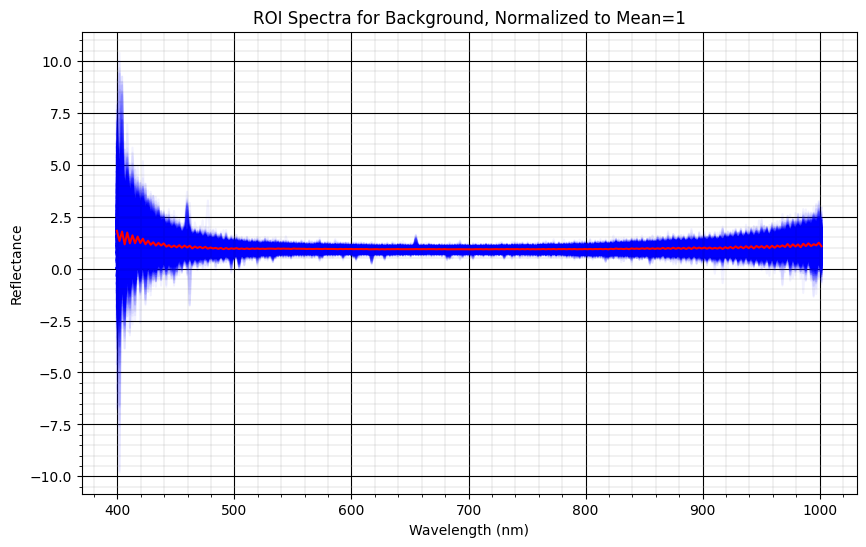

In [12]:
# plot the mean (red) and all individual spectra (blue) of each class, scaling all spectra to have mean value of 1
for name in roi_names:
    class_spectra = spectra[spectra_names==name,:]
    class_nSpec = class_spectra.shape[0]
    plt.figure(figsize=(10,6)) 
    for i in range(class_nSpec):
        plt.plot(wl,class_spectra[i,:].flatten()/np.mean(class_spectra[i,:].flatten()), color='b', alpha=0.05)
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.plot(wl, means[name]/np.mean(means[name]), color='r')
plt.title(f'ROI Spectra for {name}, Normalized to Mean=1')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.grid(True)

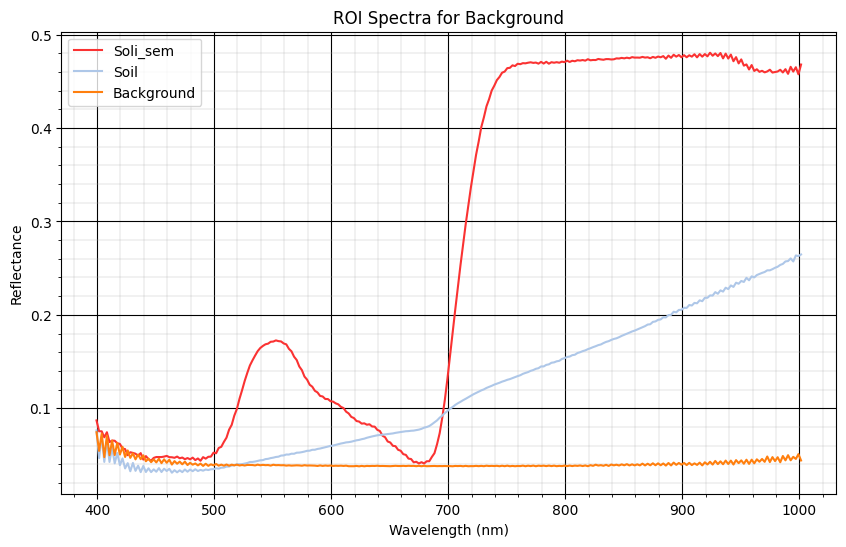

In [13]:
# plot all the means together
plt.figure(figsize=(10,6)) 
for name in roi_names:
    plt.plot(wl, means[name], label=name, color=roi_colors[name])
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.title(f'ROI Spectra for {name}')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend()
plt.grid(True)

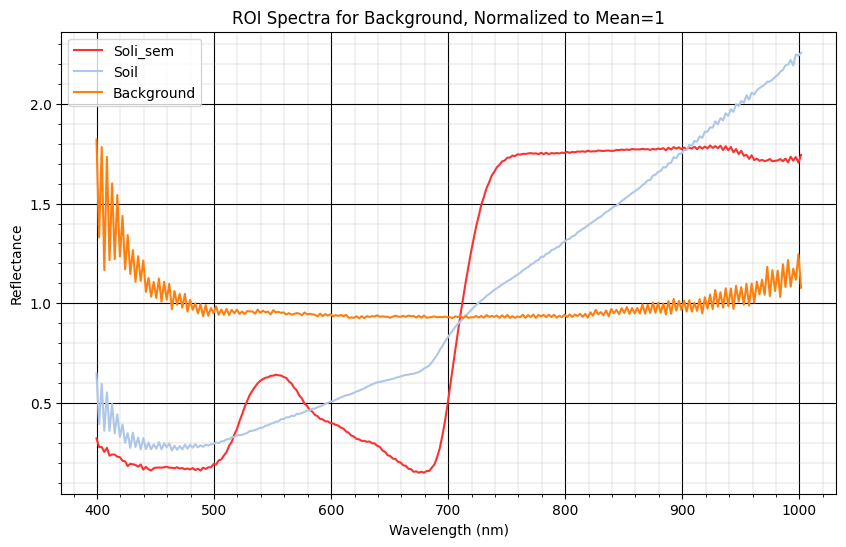

In [14]:
# plot all the means together
plt.figure(figsize=(10,6)) 
for name in roi_names:
    plt.plot(wl, means[name]/np.mean(means[name]), label=name, color=roi_colors[name])
plt.title(f'ROI Spectra for {name}, Normalized to Mean=1')
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend()
plt.grid(True)

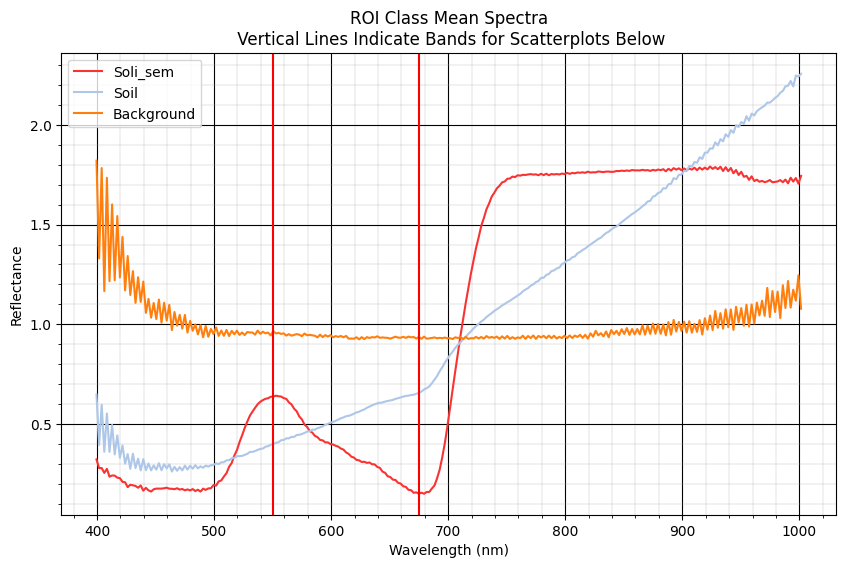

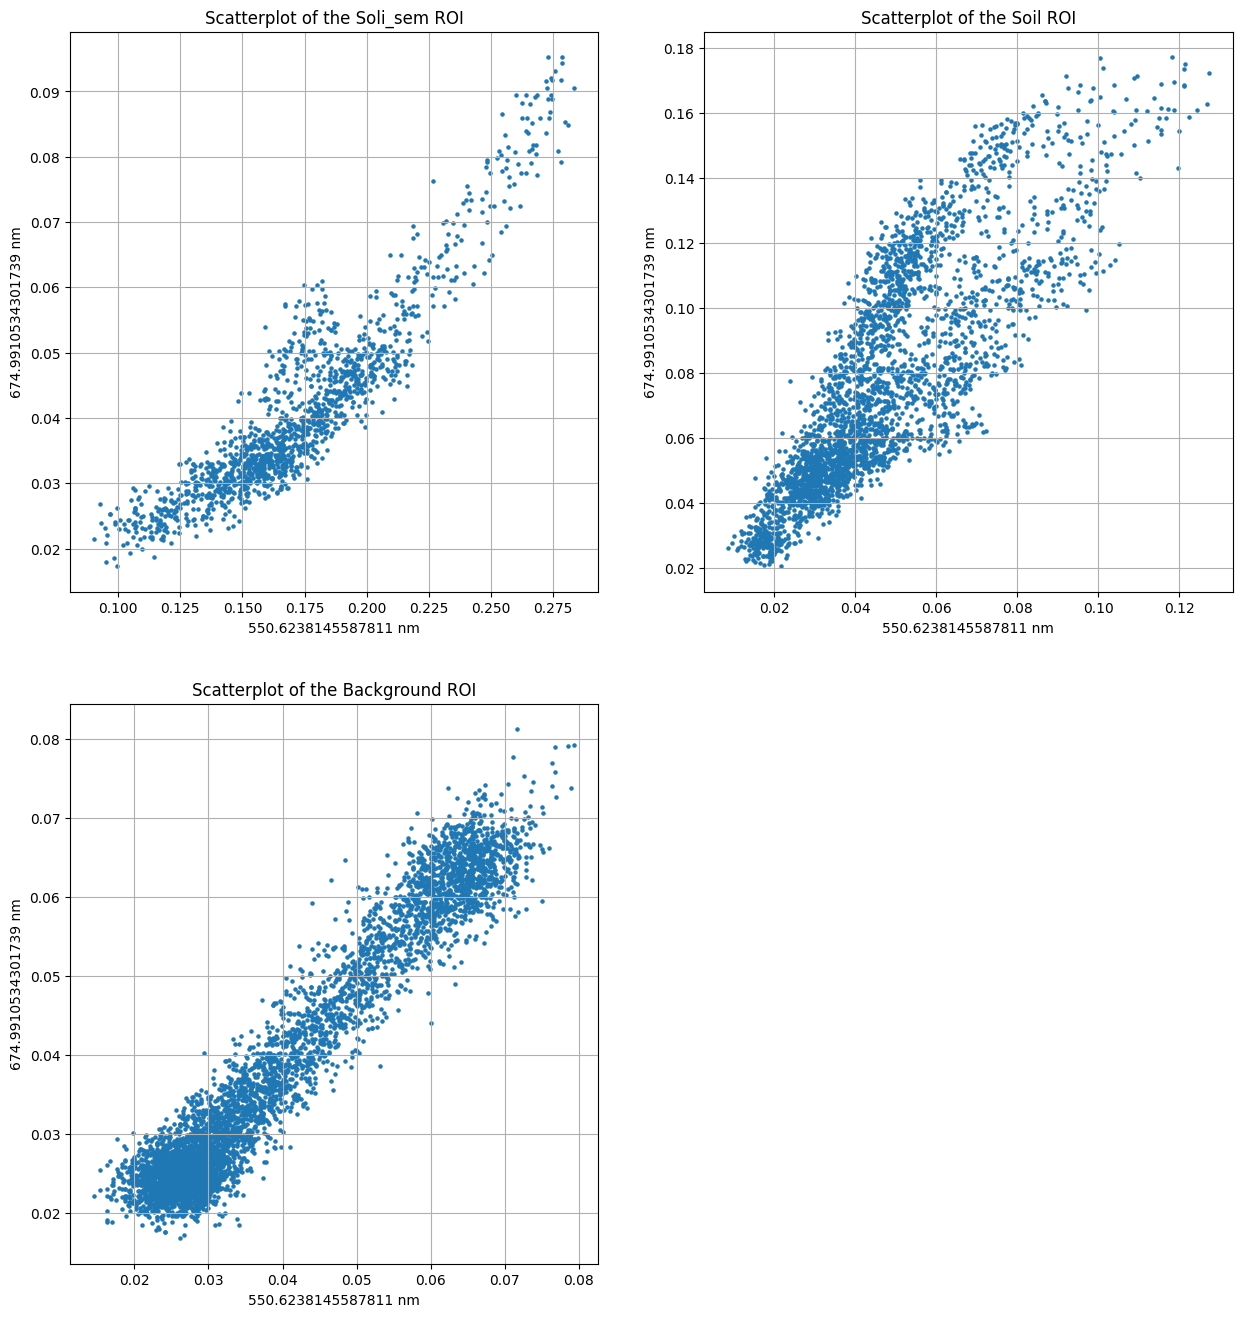

In [15]:
# Plot the class Means, then a scatterplot of each class on the same 2 bands
b1 = np.argmin(np.abs(wl-550))# index for band 1 for scatterplots
b2 = np.argmin(np.abs(wl-675))# index for band 2 for scatterplots

plt.figure(figsize=(10,6)) 
for name in roi_names:
    plt.plot(wl, means[name]/np.mean(means[name]), label=name, color=roi_colors[name])
plt.axvline(wl[b1], color='red')
plt.axvline(wl[b2], color='red')
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend()
plt.title(f'ROI Class Mean Spectra\n Vertical Lines Indicate Bands for Scatterplots Below')
plt.legend()
plt.grid(True)

nPlotRows = int(np.ceil(len(roi_names)/2))
plt.figure(figsize=(15,int(8*nPlotRows)))
i = 0
for name in roi_names:
    plt.subplot(nPlotRows, 2, i+1)  
    plt.title(f'Scatterplot of the {name} ROI')
    class_spectra = spectra[spectra_names==name,:]
    plt.scatter(class_spectra[:,b1], class_spectra[:,b2], s=5)
    plt.xlabel(f'{wl[b1]} nm')
    plt.ylabel(f'{wl[b2]} nm')
    plt.grid(True);
    i = i + 1

# PART 4: Viewing scatterplots of the ROI spectra

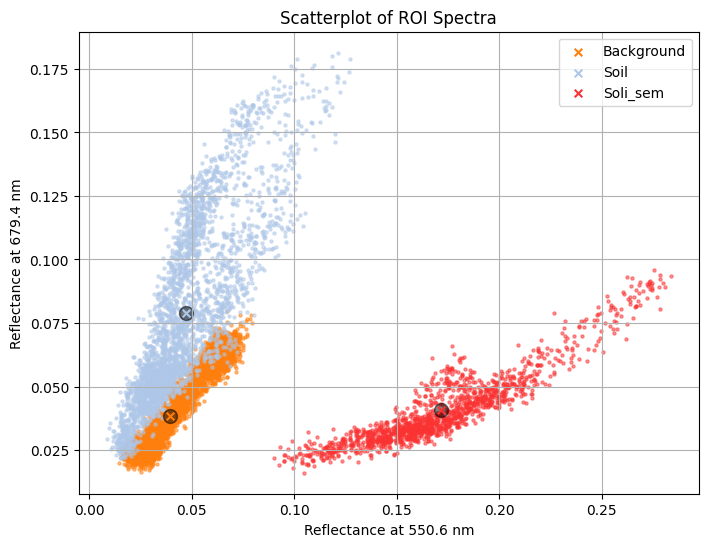

In [16]:
# Create a scatterplot of the data
i1 = np.argmin(np.abs(wl-550))
i2 =  np.argmin(np.abs(wl-680))

# sort by number of pixels in each ROI
pixCount = []
for name in roi_names:
    pixCount.append(np.sum(roi_masks[name]))
pixCount = np.asarray(pixCount)
idx_order = np.argsort(-pixCount)

plt.figure(figsize=(8,6))

# plot all of the spectra for this class
for i in idx_order:
    # get the ROI name
    name = roi_names[i]
    # get the indices for the spectra for this class
    class_spectra = spectra[spectra_names==name,:]    
    # scatterplot the class spectra at this band
    plt.scatter(class_spectra[:,i1], class_spectra[:,i2], s=5, color=roi_colors[name], alpha=0.5);
    
    
# plot the class mean spectrum for this class
for i in idx_order:
    # get the ROI name
    name = roi_names[i]
    # scatterplot the class mean spectrum at this band
    plt.scatter(means[name][i1], means[name][i2], s=100, color='k', alpha=0.5);
    plt.scatter(means[name][i1], means[name][i2], marker='x', s=30, label=name, color=roi_colors[name]);
    
plt.grid(True)
plt.legend()
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of ROI Spectra');

# PART 5: Viewing PCA-transformed scatterplots of the ROI spectra

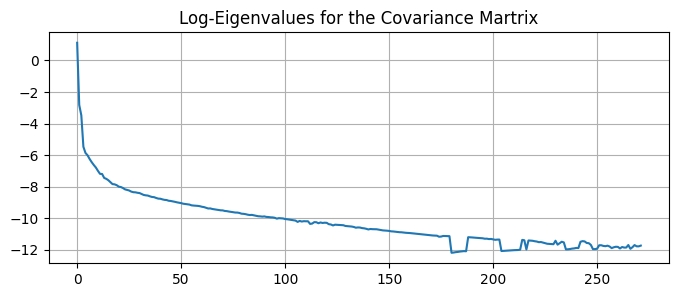

In [17]:
# compute mean and covariance of the spectra
mu = np.mean(spectra, axis=0)
C = np.cov(spectra.T)

# Compute the eigenvectors, eigenvalues, and whitening matrix
evals,evecs = np.linalg.eig(C)
# Plot the eigenvalues to examine stability 
# (Only the first N-1 of these will be meaningful, where N = # classes)
plt.figure(figsize=(8,3))
plt.plot(np.log(evals))
plt.grid(True)
plt.title('Log-Eigenvalues for the Covariance Martrix')
# truncate the small eigenvalues to stablize the inverse
tol = 10**(-8)
evals[evals<tol] = tol
DiagMatrix = np.diag(evals**(-1/2))
W = np.matmul(evecs,DiagMatrix)

# whiten the spectra
Wspectra = np.matmul(W.T, (spectra-mu).T).T

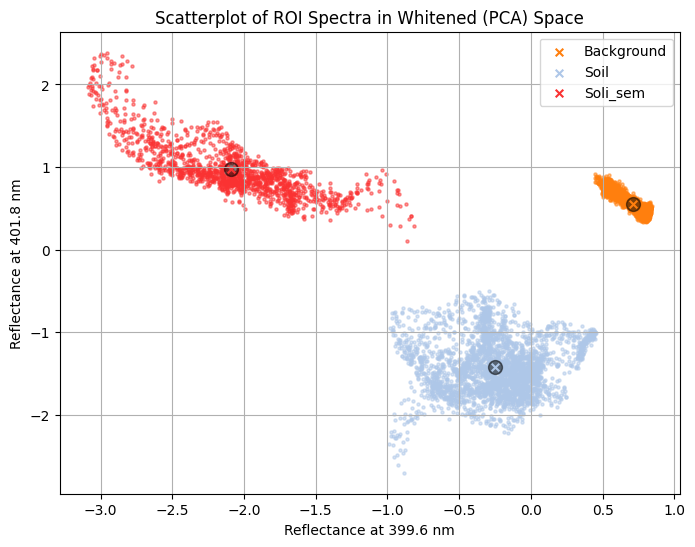

In [18]:
# Create a scatterplot of the data
i1 = 0
i2 = 1

# sort by number of pixels in each ROI
pixCount = []
for name in roi_names:
    pixCount.append(np.sum(roi_masks[name]))
pixCount = np.asarray(pixCount)
idx_order = np.argsort(-pixCount)

plt.figure(figsize=(8,6))

Wmeans = {}
# plot all of the spectra for this class
for i in idx_order:
    # get the ROI name
    name = roi_names[i]
    # get the indices for the spectra for this class
    class_spectra = Wspectra[spectra_names==name,:]   
    Wmeans[name] = np.mean(class_spectra, axis=0)
    # scatterplot the class spectra at this band
    plt.scatter(class_spectra[:,i1], class_spectra[:,i2], s=5, color=roi_colors[name], alpha=0.5);
    
    
# plot the class mean spectrum for this class
for i in idx_order:
    # get the ROI name
    name = roi_names[i]
    # scatterplot the class mean spectrum at this band
    plt.scatter(Wmeans[name][i1], Wmeans[name][i2], s=100, color='k', alpha=0.5);
    plt.scatter(Wmeans[name][i1], Wmeans[name][i2], marker='x', s=30, label=name, color=roi_colors[name]);
    
plt.grid(True)
plt.legend()
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of ROI Spectra in Whitened (PCA) Space');

### Observe that there is often overlap here between vegetation species, or more generally between similar classes.

# Part 6: Viewing LDA-transformed scatterplots of the ROI spectra

### on LDA from https://en.wikipedia.org/wiki/Linear_discriminant_analysis
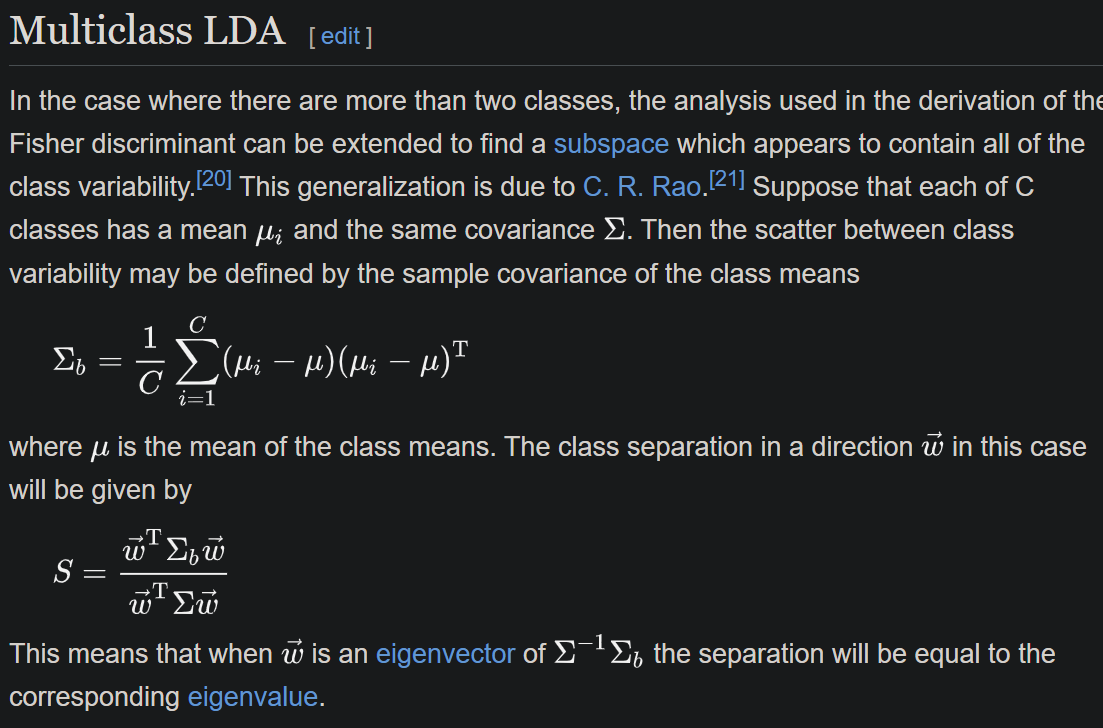

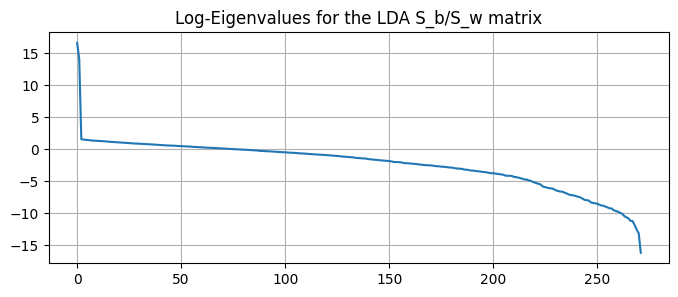

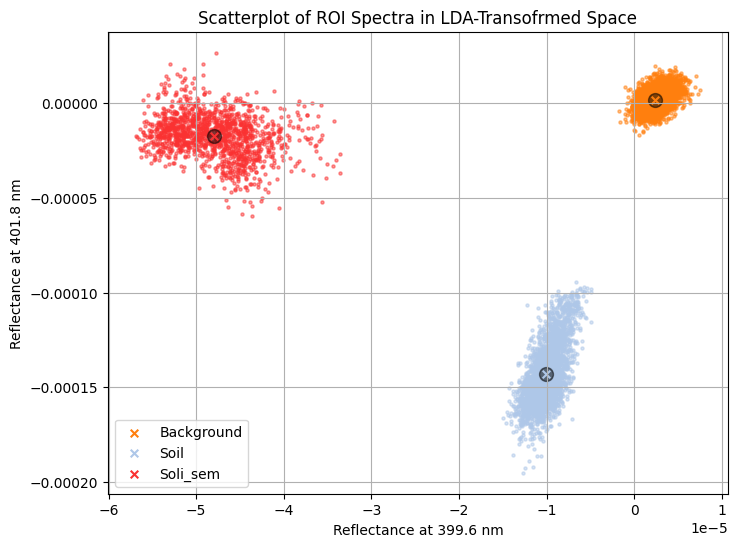

In [19]:
# ----- Compute the LDA Transform -----

# Compute the covaraince (often called the within-class-scatter in LDA, denoted S_W)
nClasses = len(roi_names)
nb = spectra.shape[1]
nSpec = spectra.shape[0]
C = np.zeros((nb,nb)) # covariance (Sigma in the Wikipedia page)
for name in roi_names:
    # get the spectra for this class
    class_spectra = spectra[spectra_names==name,:]    
    # compute the covariance for this class
    C_class = np.cov(class_spectra.T)
    # compute the number of spectra in this class
    nSpec_class = class_spectra.shape[0]
    # add the covariance of this class,
    # weighted by the fraction of total pixels that come from this class
    C = C + (nSpec_class/nSpec)*C_class 
    
# Computing the coavariance of the means (often called the between-class scatter in LDA, denoted S_b)
Cb = np.zeros((nb,nb))
for name in roi_names:
    mu_diff = np.reshape((means[name] - mu), (nb,1))
    #Cb = Cb + (1/nClasses)*np.matmul(mu_diff, mu_diff.T) # <---- This formula is for balanced datasets
    nSpec_class = np.sum(spectra_names==name)
    Cb = Cb + (nSpec_class)*np.matmul(mu_diff, mu_diff.T) # <---- This formula is for imbalanced datasets

# Compute SVD of S_W^(-1) S_B
evecs, evals, Vt = np.linalg.svd(np.linalg.pinv(C).dot(Cb))
# Plot the eigenvalues to examine stability 
# (Only the first N-1 of these will be meaningful, where N = # classes)
plt.figure(figsize=(8,3))
plt.plot(np.log(evals))
plt.grid(True)
plt.title('Log-Eigenvalues for the LDA S_b/S_w matrix')
# truncate the small eigenvalues to stablize the inverse
tol = 10**(-8)
evals[evals<tol] = tol
DiagMatrix = np.diag(evals**(-1/2))
W_lda = np.matmul(evecs,DiagMatrix)

# LDA-transform the spectra
LDA_spectra = np.matmul(W_lda.T, (spectra).T).T



# ----- Plot the Transformed Data -----
# Create a scatterplot of the data
i1 = 0
i2 = 1
# sort by number of pixels in each ROI
pixCount = []
for name in roi_names:
    pixCount.append(np.sum(roi_masks[name]))
pixCount = np.asarray(pixCount)
idx_order = np.argsort(-pixCount)
# Create the scatterplot of the LDA-transformed data
plt.figure(figsize=(8,6))
LDA_means = {}
# plot all of the spectra for this class
for i in idx_order:
    # get the ROI name
    name = roi_names[i]
    # get the indices for the spectra for this class
    class_spectra = LDA_spectra[spectra_names==name,:]   
    LDA_means[name] = np.mean(class_spectra, axis=0)
    # scatterplot the class spectra at this band
    plt.scatter(class_spectra[:,i1], class_spectra[:,i2], s=5, color=roi_colors[name], alpha=0.5);
# plot the class mean spectrum for this class
for i in idx_order:
    # get the ROI name
    name = roi_names[i]
    # scatterplot the class mean spectrum at this band
    plt.scatter(LDA_means[name][i1], LDA_means[name][i2], s=100, color='k', alpha=0.5);
    plt.scatter(LDA_means[name][i1], LDA_means[name][i2], marker='x', s=30, label=name, color=roi_colors[name]);
plt.grid(True)
plt.legend()
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of ROI Spectra in LDA-Transofrmed Space');

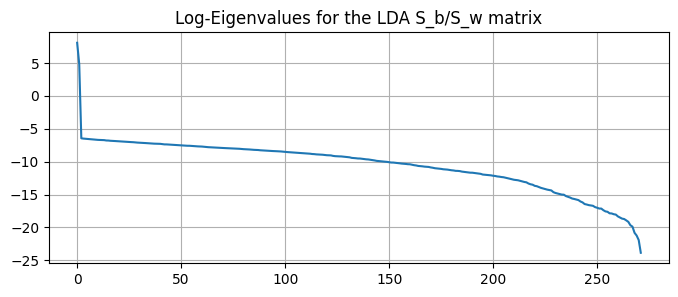

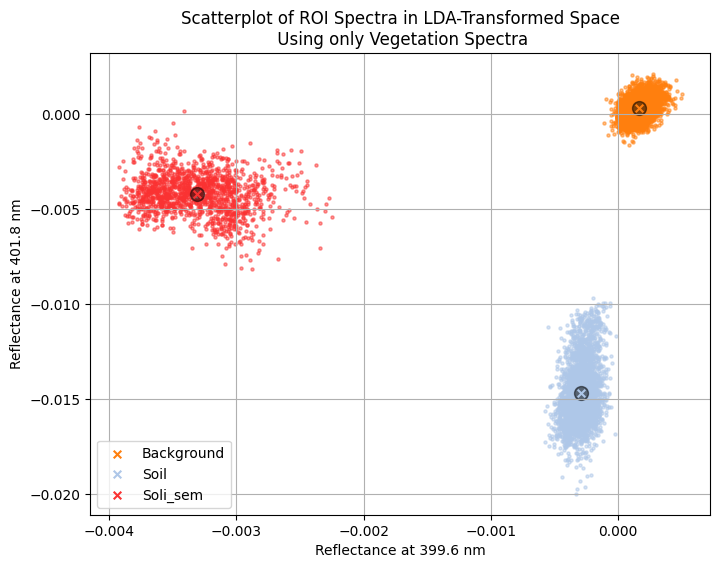

In [20]:
#roi_names_veg = ['Baccharis Halimifolia', 'Background Healthy', 'Background Scenesced']
roi_names_veg = ['Soli_sem', 'Soil', 'Background']

# ----- Compute the LDA Transform -----

# Compute the covaraince (often called the within-class-scatter in LDA, denoted S_W)
nClasses = len(roi_names_veg)
nb = spectra.shape[1]
C = np.zeros((nb,nb)) # covariance (Sigma in the Wikipedia page)
for name in roi_names_veg:
    # get the spectra for this class
    class_spectra = spectra[spectra_names==name,:]    
    # compute the covariance for this class
    C_class = np.cov(class_spectra.T)
    # compute the number of spectra in this class
    nSpec_class = class_spectra.shape[0]
    # add the covariance of this class,
    # weighted by the fraction of total pixels that come from this class
    C = C + (nSpec_class/nSpec)*C_class 
    
# Computing the coavariance of the means (often called the between-class scatter in LDA, denoted S_b)
Cb = np.zeros((nb,nb))
for name in roi_names_veg:
    mu_diff = np.reshape((means[name] - mu), (nb,1))
    Cb = Cb + (1/nClasses)*np.matmul(mu_diff, mu_diff.T)

# Compute evals and evecs of S_W^(-1) S_B, and then the LDA-Transform matrix
evecs, evals, Vt = np.linalg.svd(np.linalg.pinv(C).dot(Cb))
# Plot the eigenvalues to examine stability 
# (Only the first N-1 of these will be meaningful, where N = # classes)
plt.figure(figsize=(8,3))
plt.plot(np.log(evals))
plt.grid(True)
plt.title('Log-Eigenvalues for the LDA S_b/S_w matrix')
# truncate the small eigenvalues to stablize the inverse
tol = 10**(-8)
evals[evals<tol] = tol
DiagMatrix = np.diag(evals**(-1/2))
W_lda = np.matmul(evecs,DiagMatrix)

# LDA-transform the spectra
LDA_spectra = np.matmul(W_lda.T, (spectra).T).T



# ----- Plot the Transformed Data -----
# Create a scatterplot of the data
i1 = 0
i2 = 1
# sort by number of pixels in each ROI
pixCount = []
for name in roi_names_veg:
    pixCount.append(np.sum(roi_masks[name]))
pixCount = np.asarray(pixCount)
idx_order = np.argsort(-pixCount)
# Create the scatterplot of the LDA-transformed data
plt.figure(figsize=(8,6))
LDA_means = {}
# plot all of the spectra for this class
for i in idx_order:
    # get the ROI name
    name = roi_names_veg[i]
    # get the indices for the spectra for this class
    class_spectra = LDA_spectra[spectra_names==name,:]   
    LDA_means[name] = np.mean(class_spectra, axis=0)
    # scatterplot the class spectra at this band
    plt.scatter(class_spectra[:,i1], class_spectra[:,i2], s=5, color=roi_colors[name], alpha=0.5);
# plot the class mean spectrum for this class
for i in idx_order:
    # get the ROI name
    name = roi_names_veg[i]
    # scatterplot the class mean spectrum at this band
    plt.scatter(LDA_means[name][i1], LDA_means[name][i2], s=100, color='k', alpha=0.5);
    plt.scatter(LDA_means[name][i1], LDA_means[name][i2], marker='x', s=30, label=name, color=roi_colors[name]);
plt.grid(True)
plt.legend()
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of ROI Spectra in LDA-Transformed Space\n Using only Vegetation Spectra');

# Part 7: Computing Mahalanobis Distances

In [21]:
nClasses = len(roi_names)
nb = spectra.shape[1]
C = np.zeros((nb,nb)) # covariance (Sigma in the Wikipedia page)
for name in roi_names:
    # get the spectra for this class
    class_spectra = spectra[spectra_names==name,:]    
    # compute the covariance for this class
    C_class = np.cov(class_spectra.T)
    # compute the number of spectra in this class
    nSpec_class = class_spectra.shape[0]
    # add the covariance of this class,
    # weighted by the fraction of total pixels that come from this class
    C = C + (nSpec_class/nSpec)*C_class 

# compute the whitening matrix
evals,evecs = np.linalg.eig(C)
tol = 10**(-6)
evals[evals<tol] = tol
DiagMatrix = np.diag(evals**(-1/2))
#roi_Ws[name] = np.matmul(evecs,DiagMatrix)
#DiagMatrix = np.diag(evals**(-1/2))
W_all = np.matmul(evecs,DiagMatrix)
    
# Create array to hold the Mahalanobis Distance
MD = np.zeros((nSpec, nClasses))

# compute the mean and covariance for each class
roi_means = {}
roi_Ws = {}
i = 0
for name in roi_names:
    # get the spectra for this class
    class_spectra = spectra[spectra_names==name,:] 
    # compute the covariance for this class
    mu = np.mean(class_spectra, axis=0)
    C = np.cov(class_spectra.T)
    # Compute the eigenvectors, eigenvalues, and whitening matrix
    evals,evecs = np.linalg.eig(C)
    # truncate the small eigenvalues to stablize the inverse
    tol = 10**(-8)
    evals[evals<tol] = tol
    DiagMatrix = np.diag(evals**(-1/2))
    roi_Ws[name] = np.matmul(evecs,DiagMatrix)
    DiagMatrix = np.diag(evals**(-1/2))
    W_this_class = np.matmul(evecs,DiagMatrix)
    
    if np.sum(spectra_names==name) < 100:
        W = W_all
    else:
        W = W_this_class        
    
    MD_class = np.sqrt(np.sum((np.matmul(W.T, (spectra-mu).T).T)**2, axis=1))
    MD[:,i] = MD_class
    i = i + 1

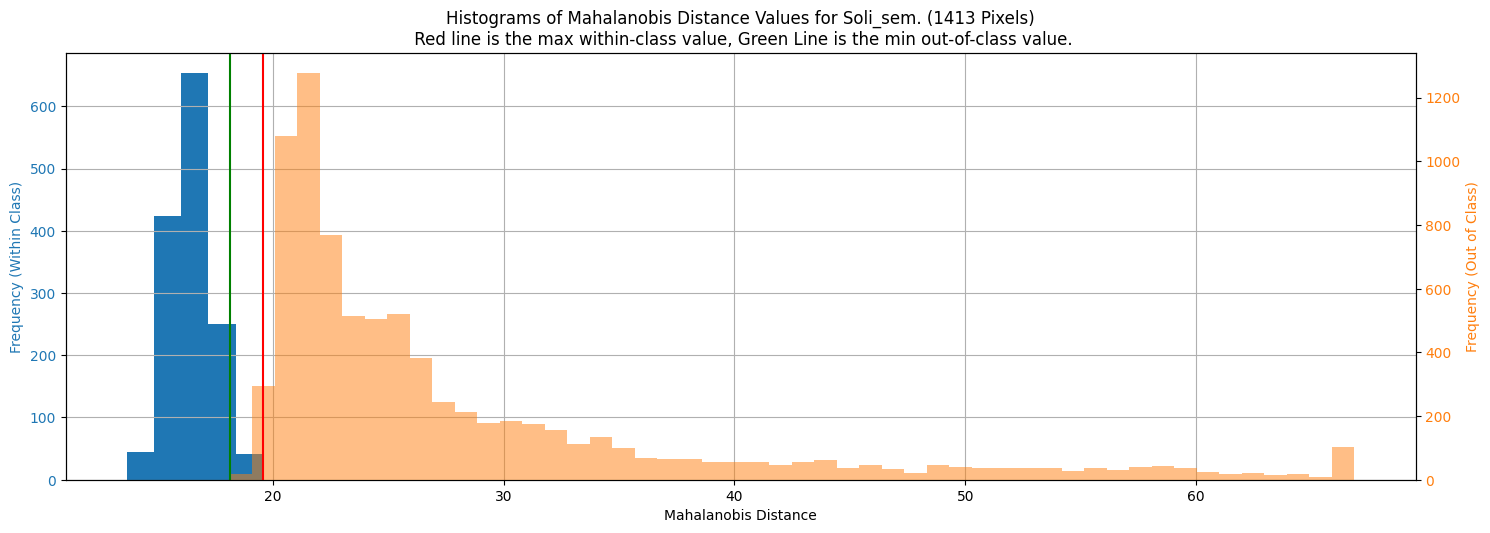

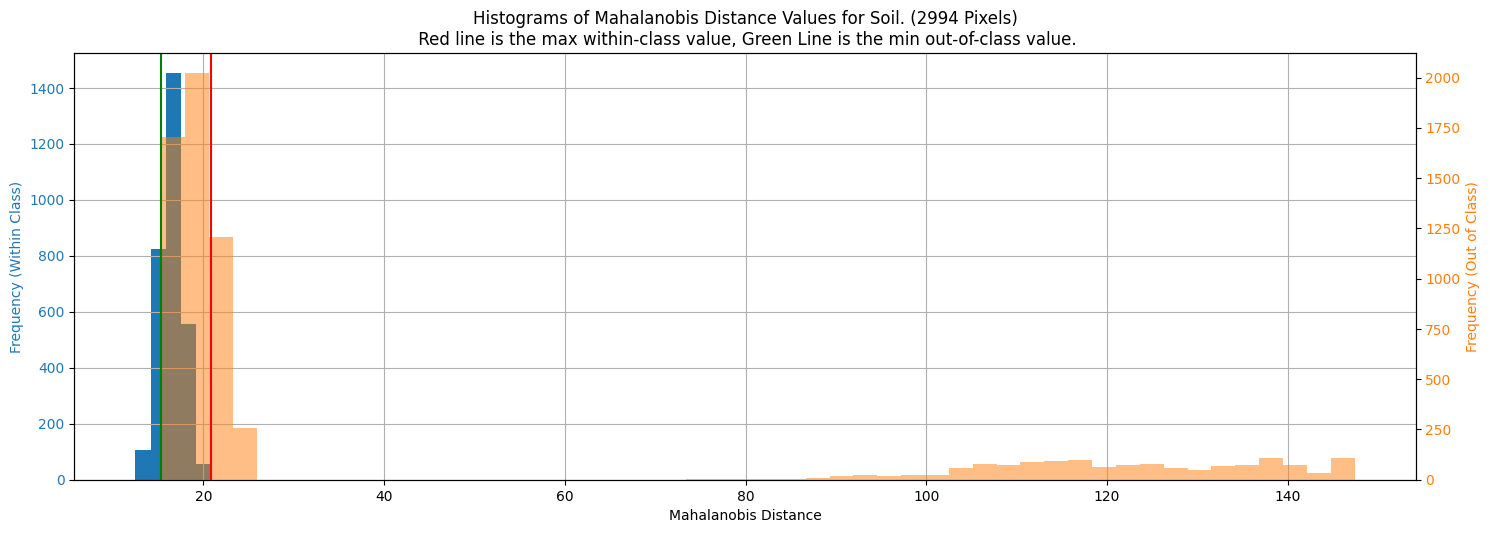

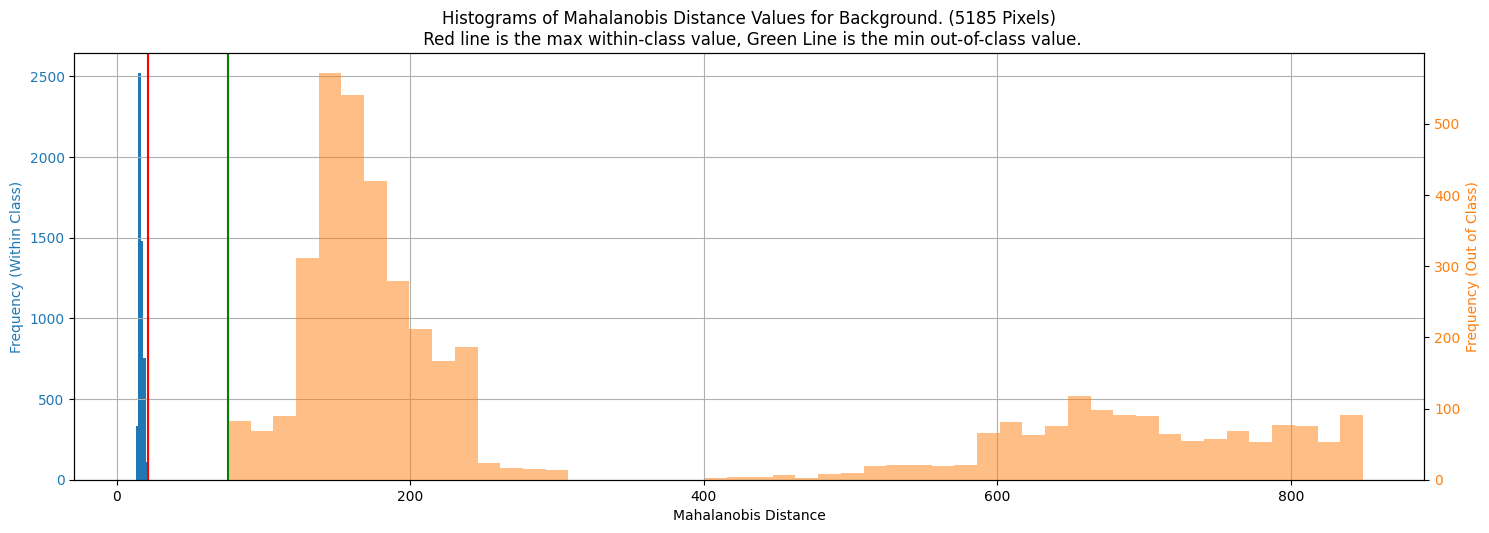

In [22]:
# Plot within-class and out-of-class histograms, giving each their own axis
for classIndex in range(nClasses):
    fig, ax1 = plt.subplots(figsize=(15,5))

    name = roi_names[classIndex]
    MD_this_class = MD[:,classIndex]
    MD_within_class = MD_this_class[spectra_names==name]
    MD_other_classes = MD_this_class[spectra_names!=name]
    MD_other_classes = np.clip(MD_other_classes, a_min=0, a_max=np.percentile(MD_other_classes, 99))  
    nSpectra_thei_class = np.sum(spectra_names==name)

    color = 'tab:blue'
    ax1.set_xlabel('Mahalanobis Distance')
    ax1.set_ylabel('Frequency (Within Class)', color=color)    
    bins = min(5, len(MD_within_class) // 10)
    if bins<5: 
        bins=5
    ax1.hist(MD_within_class, bins=bins);
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    
    color = 'tab:orange'
    ax2.set_ylabel('Frequency (Out of Class)', color=color)  # we already handled the x-label with ax1  
    bins = min(50, len(MD_other_classes) // 5)
    ax2.hist(MD_other_classes, bins=bins, color=color, alpha=0.5);
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.axvline(np.max(MD_within_class), color='r')    
    plt.axvline(np.min(MD_other_classes), color='g')

    ax1.grid(True)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(f'Histograms of Mahalanobis Distance Values for {name}. ({nSpectra_thei_class} Pixels)\n Red line is the max within-class value, Green Line is the min out-of-class value.');
    plt.show()

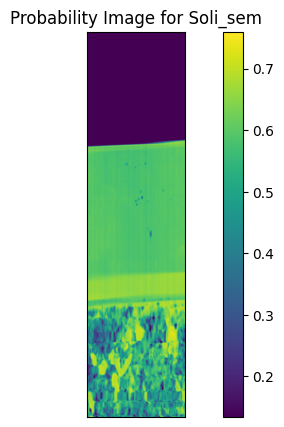

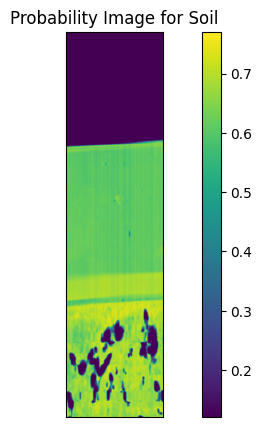

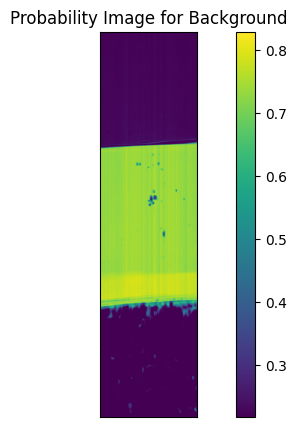

In [ ]:
nClasses = len(roi_names)
nb = spectra.shape[1]
C = np.zeros((nb,nb)) # covariance (Sigma in the Wikipedia page)
for name in roi_names:
    # get the spectra for this class
    class_spectra = spectra[spectra_names==name,:]    
    # compute the covariance for this class
    C_class = np.cov(class_spectra.T)
    # compute the number of spectra in this class
    nSpec_class = class_spectra.shape[0]
    # add the covariance of this class,
    # weighted by the fraction of total pixels that come from this class
    C = C + (nSpec_class/nSpec)*C_class 

# compute the whitening matrix
evals,evecs = np.linalg.eig(C)
tol = 10**(-6)
evals[evals<tol] = tol
DiagMatrix = np.diag(evals**(-1/2))
roi_Ws[name] = np.matmul(evecs,DiagMatrix)
DiagMatrix = np.diag(evals**(-1/2))
W_all = np.matmul(evecs,DiagMatrix)
    
# Create array to hold the Mahalanobis Distance
MD = np.zeros((nSpec, nClasses))

# compute the mean and covariance for each class
roi_means = {}
roi_Ws = {}
for name in roi_names:
    plt.figure(figsize=(10,5))
    # get the spectra for this class
    class_spectra = spectra[spectra_names==name,:] 
    # compute the covariance for this class
    mu = np.mean(class_spectra, axis=0)
    C = np.cov(class_spectra.T)
    # Compute the eigenvectors, eigenvalues, and whitening matrix
    evals,evecs = np.linalg.eig(C)
    # truncate the small eigenvalues to stablize the inverse
    tol = 10**(-8)
    evals[evals<tol] = tol
    DiagMatrix = np.diag(evals**(-1/2))
    roi_Ws[name] = np.matmul(evecs,DiagMatrix)
    DiagMatrix = np.diag(evals**(-1/2))
    W_this_class = np.matmul(evecs,DiagMatrix)
    
    if np.sum(spectra_names==name) < 100:
        W = W_all
    else:
        W = W_this_class        
    
    MD_class = np.sqrt(np.sum((np.matmul(W.T, (im.List-mu).T).T)**2, axis=1))
    MD_class[MD_class>100] = 100
    MD_class = MD_class/np.mean(MD_class)
    MD_class = np.real(MD_class)
    #MD_class = MD_class - np.min(MD_class)
    MD_class_im = np.reshape(MD_class, (nr,nc))
    plt.imshow(np.exp(-MD_class_im))
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Probability Image for {name}')
    plt.colorbar()

# WORK-IN-PROGRESS Evaluation Metrics

In [ ]:
# See: https://scikit-learn.org/1.5/api/sklearn.metrics.html


In [1]:
from sklearn.metrics import classification_report

y_true = gt_list[np.where(gt_list>0)[0]]
LDA_class_list = np.argmin(MD_all, axis=1)
y_pred = LDA_class_list[np.where(gt_list>0)[0]]


# modifying for scoring
y_true = y_true - 1
y_true = (y_true).astype(int)

cr = classification_report(y_true, y_pred, target_names=class_names)

print(cr)

NameError: name 'gt_list' is not defined

In [ ]:
MD_all[2000,:]**(-1)

array([0.01496713, 0.02235861, 0.03220612, 0.02325897, 0.01911406,
       0.04074989, 0.05469147, 0.03299266, 0.04316236, 0.0349384 ,
       0.03745206, 0.05710765])

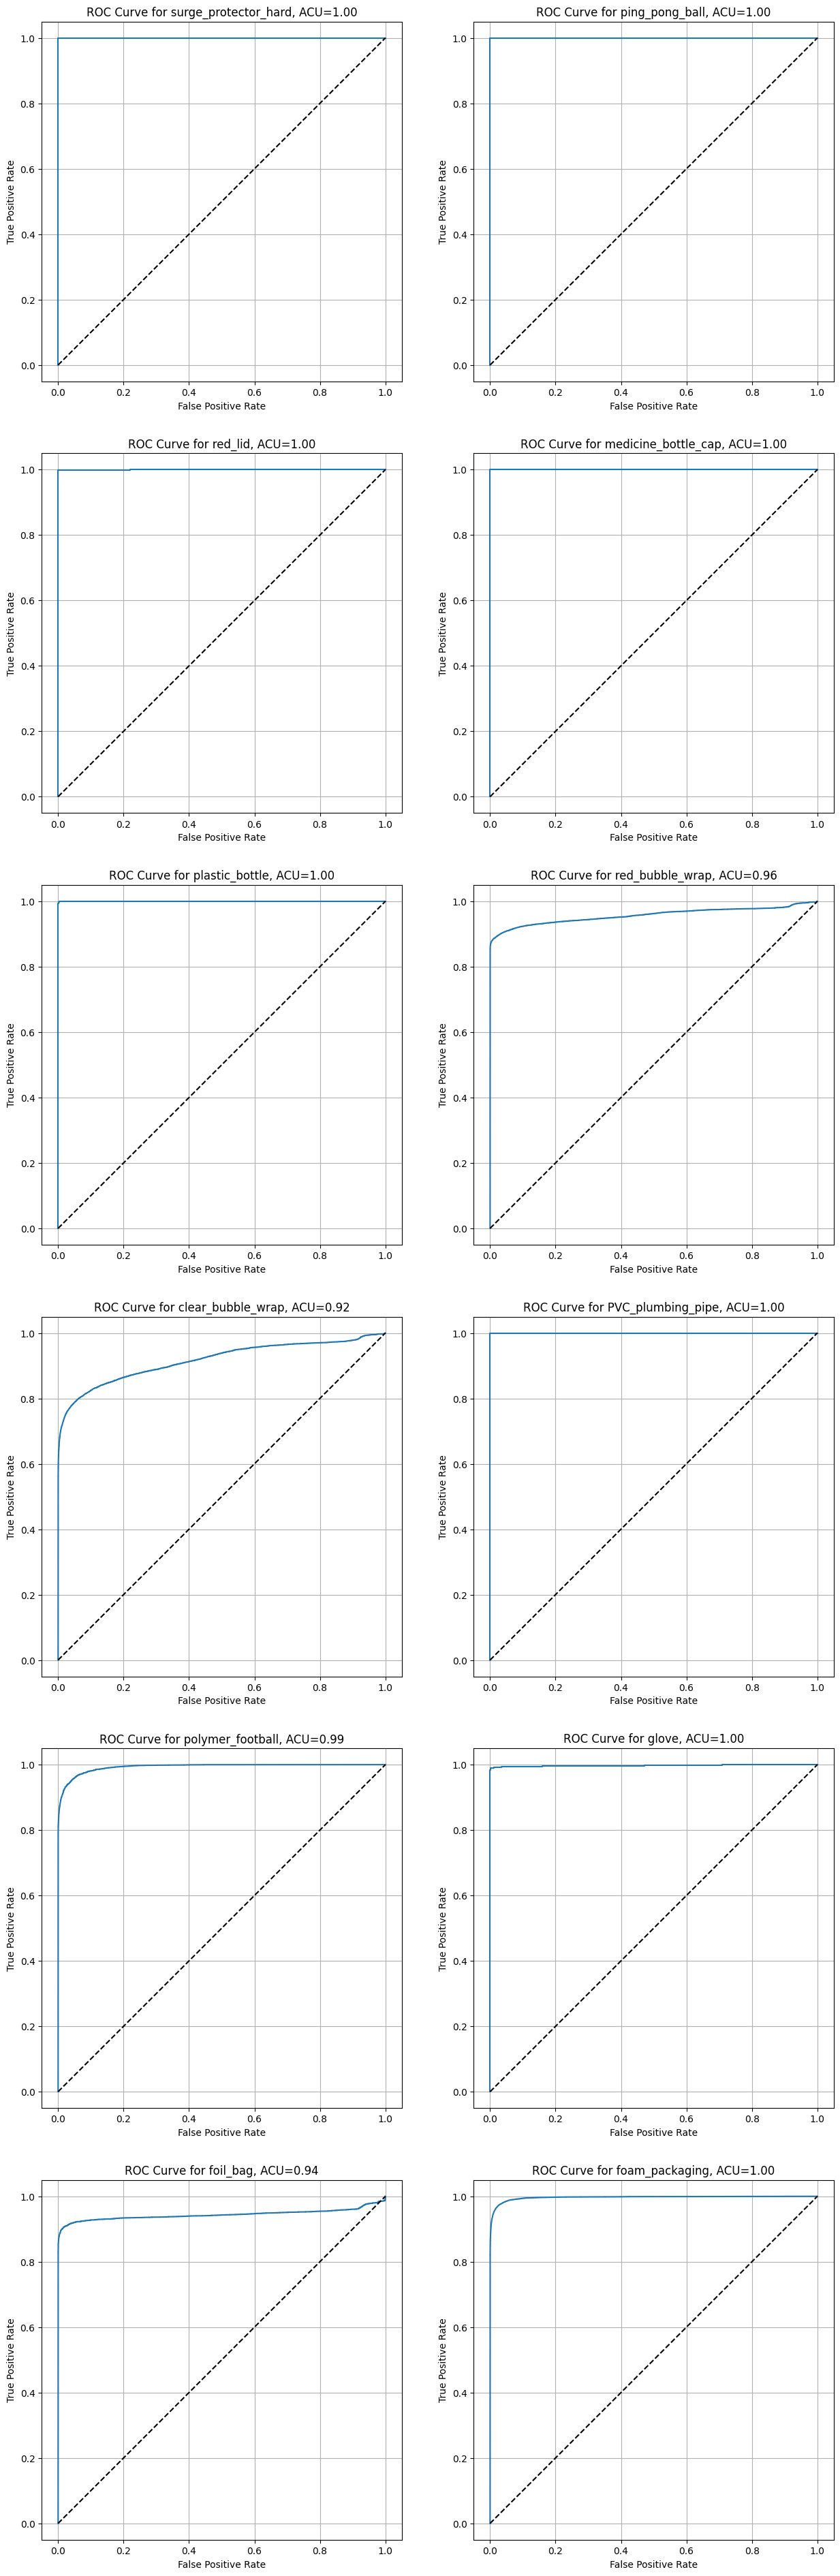

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# get a predicted score value (higher value => more likely to be in the class)
y_pred_scores = MD_all[np.where(gt_list>0)[0],:]**(-1)
y_true = gt_list[np.where(gt_list>0)[0]]

plt.figure(figsize=(15,int(8*nPlotRows)))
for i in range(nClasses):
    plt.subplot(nPlotRows, 2, i+1) 
    
    y_true_this_class = (y_true==(i+1))
    y_pred_scores_this_class = y_pred_scores[:,i]
    
    fpr, tpr, thresholds = roc_curve(y_true_this_class, y_pred_scores_this_class)
    auc = roc_auc_score(y_true_this_class, y_pred_scores_this_class)
    
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f'ROC Curve for {class_names[i]}, ACU={auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)